In [1]:
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
import torch
import torch.nn as nn

from torchvision import datasets
from torch.optim import SGD
from torch.optim import Adam

import neptune
import lovely_tensors as lt

from neptune_creds import api_token

lt.monkey_patch()

device = "cuda" if torch.cuda.is_available() else "cpu"
print( f"device: {device}" )

device: cpu


In [10]:
train_set = datasets.MNIST('data/', download=True, train=True)
train_images = train_set.data
train_targets = train_set.targets

test_set = datasets.MNIST('data/', download=True, train=False)
test_images = test_set.data
test_targets = test_set.targets

class MNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.unsqueeze(1)
        x = x.view(-1,28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)
    
def get_data(batch_size=32):
    train = MNISTDataset(train_images, train_targets)
    train_dl = DataLoader(train, batch_size=batch_size, shuffle=True,)
    test = MNISTDataset(test_images, test_targets)
    test_dl = DataLoader(test, batch_size=len(test_images), shuffle=True)
    return train_dl, test_dl

In [7]:
model = nn.Sequential(
    nn.Linear(28 * 28, 30),
    nn.Tanh(),
    nn.Linear(30, 20),
    nn.Tanh(),
    nn.Linear(20, 10),
    nn.LogSoftmax(dim=1)
    )

model.load_state_dict(torch.load('models/nnMnist97p.pt'))


<All keys matched successfully>

- for correctly classified images: invert pixels in a loop and classify after every loop
- count robus images which are still correctly classified after all 784 iterations
- count the misclassifications (which combinations of digits are misclassified)

In [11]:
train_dl, _ = get_data(batch_size=1)
log_dict = {"predicted": [], "actual": []}
from itertools import permutations
class_perm_dict = {str(key): 0 for key in permutations(range(0, 10), 2)}
model_reacted = []
failed_combinations = []

# def modify_misses(x, model, predicted_class, actual_class):
#     for i, px in enumerate(range(28*28)):
#     # invert a pixel and see if the prediction changes
#     x[0, px] = 1 - x[0, px]
#     y_hat = model.forward(x)
#     predicted_class = torch.argmax(y_hat, dim=1).item()
    
#     log_dict["predicted"].append(predicted_class)
#     log_dict["actual"].append(actual_class)
    
#     if predicted_class != actual_class:
#         model_reacted.append(px)
#         failed_combinations.append(zip(predicted_class, actual_class))

In [14]:
for i, batch in tqdm(enumerate(iter(train_dl)), total=len(train_dl)):
    x, y = batch
    y_hat = model.forward(x)
    predicted_class = torch.argmax(y_hat, dim=1).item()
    actual_class = y.item()
    
    log_dict["predicted"].append(predicted_class)
    log_dict["actual"].append(actual_class)
    
    if predicted_class == actual_class:
        # print(f"Misclassified {predicted_class} as {actual_class}")
        for px in range(28*28):
            # invert a pixel and see if the prediction changes
            x[0, px] = 1 - x[0, px]
            y_hat = model.forward(x)
            predicted_class = torch.argmax(y_hat, dim=1).item()
            
            log_dict["predicted"].append(predicted_class)
            log_dict["actual"].append(actual_class)
            
            if predicted_class != actual_class:
                model_reacted.append(px)
                failed_combinations.append((predicted_class, actual_class))
    else:
        failed_combinations.append((predicted_class, actual_class))
        model_reacted.append("unmodified")

 50%|████▉     | 29735/60000 [1:36:27<1:38:10,  5.14it/s]


KeyboardInterrupt: 

In [16]:
f"Performed {i} iterations."

'Performed 29735 iterations.'

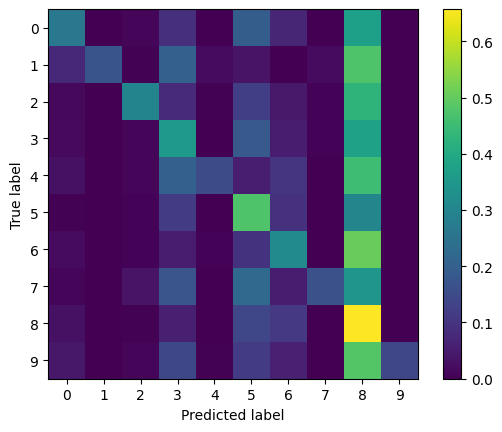

In [50]:
# plot classification matrix for all classes
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

log_df = (
    pd.DataFrame(log_dict) 
)

disp = ConfusionMatrixDisplay.from_predictions(
    log_df["actual"], 
    log_df["predicted"],
    labels=range(10),
    normalize="true",
    include_values=False,
    
    )
# disp.plot()


In [23]:

# finde the most common misclassifications
from collections import Counter
Counter(failed_combinations).most_common(10)

[((8, 1), 1214428),
 ((8, 6), 1140987),
 ((8, 9), 1090318),
 ((8, 4), 1007073),
 ((8, 2), 976416),
 ((8, 3), 866935),
 ((8, 0), 845051),
 ((8, 7), 833415),
 ((8, 5), 624127),
 ((5, 7), 545295)]

In [ ]:
# the Counter shows the pixel index as key and the count as value
matrix = np.zeros(28*28)

for i in tqdm(range(28*28)):
    c[i] = Counter(model_reacted)[i]
    
matrix = c.reshape(28, 28)
plt.heatmap(matrix, cmap="Blues")
plt.show()


In [46]:

matrix = np.zeros(28*28)
for item in Counter(model_reacted).items():
    x, y = item
    if x == "unmodified":
        break
    matrix[x] = y


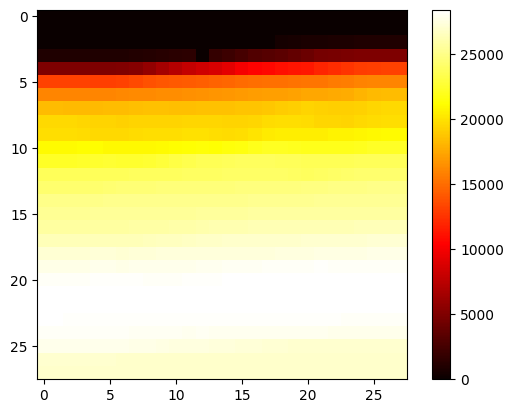

In [52]:
matrix = matrix.reshape(28, 28)
plt.imshow(matrix, cmap='hot', interpolation='nearest', )
plt.colorbar()
plt.show()


In [60]:
for i, batch in tqdm(enumerate(iter(train_dl)), total=len(train_dl)):
    x, y = batch
    y_hat = model.forward(x)
    predicted_class = torch.argmax(y_hat, dim=1)
    actual_class = y
    
    predicted_classes = torch.argmax(y_hat, dim=1)
    actual_classes = y.squeeze()
    
    log_dict["predicted"].extend(predicted_classes.tolist())
    log_dict["actual"].extend(actual_classes.tolist())

    correct_mask = predicted_classes == actual_classes
    incorrect_mask = ~correct_mask
    model_reacted.extend(["default" for _ in range(incorrect_mask.sum())])
    # log the failed combinations
    #make iterable of the two tensors predicted_classes[incorrect_mask], actual_classes[incorrect_mask]
    
    failed_tensor = torch.stack((predicted_classes[incorrect_mask], actual_classes[incorrect_mask]), dim=1)
    
    # iterate over the correct predictions and try to modify them until the model fails
    for i_sample in tqdm(range(correct_mask.sum().item())):
        
        # print(f"Misclassified {predicted_class} as {actual_class}")
        modified_x = x[i_sample, :].clone()
        for i, px in enumerate(range(28*28)):
            modified_x = modified_x.view(-1,28*28)
            # invert a pixel and see if the prediction changes
            modified_x[px] = 1 - modified_x[px]
            y_hat = model.forward(modified_x)
            predicted_class = torch.argmax(y_hat, dim=1)
            actual_class = y[i_sample]
            log_dict["predicted"].append(predicted_class.item())
            log_dict["actual"].append(actual_class.item())
            
            if predicted_class != actual_class:
                model_reacted.append(px)
                failed_tensor = torch.cat((failed_tensor, torch.cat((predicted_class, actual_class), dim=1)), dim=0)
        

  0%|          | 0/1 [00:03<?, ?it/s]


RuntimeError: zero-dimensional tensor (at position 1) cannot be concatenated